In [ ]:
# ── Cell 1: Imports & Load Combos ──────────────────────────────────
import pandas as pd
from ml_way2 import (
    load_and_normalize,
    limit_to_last_n_days,
    split_by_days,
    preprocess_1h,
    preprocess_5m,
    run_backtest,
    DATA_5M,
    DATA_1H,
    LIMITER_DAYS,
    TRAIN_PCT,
)

# load your saved top‐K CSV (adjust filename as needed)
combos = pd.read_csv("top_HistGBM_combos_filtered.csv")
combos


,ATR_WINDOW,EMA_LONG,SL_ATR_MULT,TP_ATR_MULT,VOL_MULT,RISK_PCT,REGIME_MULT,sharpe,num_entries
0,8,114,1.115595,7.894272,1.224078,0.008559,1.954206,0.799638,18


In [11]:
!pwd

/Users/harit/algo_crypto/mymodules


In [12]:
# ── Cell 2: Prepare Out-of-Sample Data ────────────────────────────
# 1) load full last-N-days data
df5  = limit_to_last_n_days(load_and_normalize(DATA_5M), LIMITER_DAYS)
df1h = limit_to_last_n_days(load_and_normalize(DATA_1H), LIMITER_DAYS)

# 2) split into train/test by day, then select the test slice
tr_days, ts_days = split_by_days(df5, TRAIN_PCT)
df5_ts  = df5[df5["datetime"].dt.normalize().isin(ts_days)].reset_index(drop=True)
df1h_ts = df1h[df1h["datetime"].dt.normalize().isin(ts_days)].reset_index(drop=True)

print(f"Out-of-sample bars (5m): {len(df5_ts)}")
print(f"Out-of-sample bars (1h): {len(df1h_ts)}")


Out-of-sample bars (5m): 15619
Out-of-sample bars (1h): 1302


In [13]:
# ── Cell 3: Backtest Each Combo ───────────────────────────────────
results = []

for idx, row in combos.iterrows():
    # extract just the parameter cols
    params = row.drop(["sharpe", "num_entries"]).to_dict()

    # preprocess
    hf = preprocess_1h(df1h_ts, params)
    b5 = preprocess_5m(df5_ts.copy(), params, hf)

    # backtest
    trades, metrics = run_backtest(b5, params)

    # attach params for reference
    metrics.update(params)
    results.append(metrics)

# assemble results
results_df = pd.DataFrame(results)
results_df



=== PARAMS {'ATR_WINDOW': 8.0, 'EMA_LONG': 114.0, 'SL_ATR_MULT': 1.1155952404844922, 'TP_ATR_MULT': 7.894271701451638, 'VOL_MULT': 1.2240778043361047, 'RISK_PCT': 0.008559256381869, 'REGIME_MULT': 1.9542056499130531} ===
Total bars: 15585
After EMA:       7974/15585
After RSI+BO:     360/15585
After ADX+ATR:   4120/15585
After 1h trend:  8688/15585
After vol spike: 3897/15585
After VWAP band: 6277/15585
After session:   14938/15585
After regime:     130/15585
After combine:      8 entries



,total_return_pct,annualized_return_pct,sharpe_ratio,max_drawdown_pct,win_rate_pct,num_trades,profit_factor,avg_win_usd,avg_loss_usd,max_win_usd,max_loss_usd,avg_duration_min,final_balance_usdt,ATR_WINDOW,EMA_LONG,SL_ATR_MULT,TP_ATR_MULT,VOL_MULT,RISK_PCT,REGIME_MULT
0,26.593947,554.188646,0.388677,-11.859752,83.333333,12,2.561236,2.530416,-4.939833,5.217098,-8.008986,8.75,73.424489,8.0,114.0,1.115595,7.894272,1.224078,0.008559,1.954206



=== PARAMS {'ATR_WINDOW': 8.0, 'EMA_LONG': 114.0, 'SL_ATR_MULT': 1.1155952404844922, 'TP_ATR_MULT': 7.894271701451638, 'VOL_MULT': 1.2240778043361047, 'RISK_PCT': 0.008559256381869, 'REGIME_MULT': 1.9542056499130531} ===
Total bars: 15585
After EMA:       7974/15585
After RSI+BO:     360/15585
After ADX+ATR:   4120/15585
After 1h trend:  8688/15585
After vol spike: 3897/15585
After VWAP band: 6277/15585
After session:   14938/15585
After regime:     130/15585
After combine:      8 entries



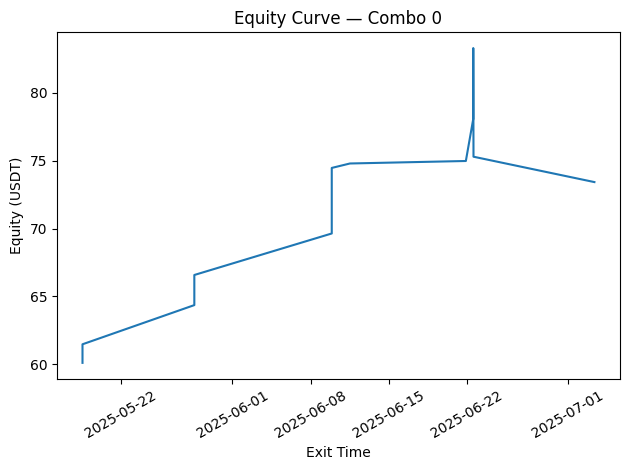

In [14]:
# ── Cell 4: (Optional) Quick Equity‐Curve Plot for Combo 0 ───────
import matplotlib.pyplot as plt

# re-run trades for combo 0 to get its trade DataFrame
params0 = combos.drop(["sharpe","num_entries"], axis=1).iloc[0].to_dict()
hf0 = preprocess_1h(df1h_ts, params0)
b50 = preprocess_5m(df5_ts.copy(), params0, hf0)
trades0, _ = run_backtest(b50, params0)

if not trades0.empty:
    plt.plot(trades0["exit_dt"], trades0["total"])
    plt.xlabel("Exit Time")
    plt.ylabel("Equity (USDT)")
    plt.title("Equity Curve — Combo 0")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    print("No trades for combo 0")
